# CNO neutrino detection in NEXT (1 metric ton)

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import math
import urllib.request
from scipy.interpolate import interp1d
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from random import random

## Neutrino Flux

Pull neutrino flux data from http://www.sns.ias.edu/~jnb/SNdata/Export/CNOspectra/

In [23]:
#Flux data for N13
f= urllib.request.urlopen("http://www.sns.ias.edu/~jnb/SNdata/Export/CNOspectra/n13.dat")
page1 = f.read().decode("utf-8")
f.close()

linesN = page1.splitlines()

rawflux_n13 = []
rawenergy_n13 = []
for line in range(len(linesN)):
    a = linesN[line]
    rawenergy_n13.append(float(a[3:13]))
    rawflux_n13.append(float(a[15:]))

flux_n13 = []
for n in range(len(rawflux_n13)):
    flux_n13.append(rawflux_n13[n]*2.78e8) 
    

#Flux data from 015
g = urllib.request.urlopen("http://www.sns.ias.edu/~jnb/SNdata/Export/CNOspectra/o15.dat")
page2 = g.read().decode("utf-8")
g.close()

linesO = page2.splitlines()

rawflux_o15 = []
rawenergy_o15 = []
for line in range(len(linesO)):
    a = linesO[line]
    rawenergy_o15.append(float(a[3:13]))
    rawflux_o15.append(float(a[15:]))
    
flux_o15 = []
for n in range(len(rawflux_o15)):
    flux_o15.append(rawflux_o15[n]*2.05e8)
    
    
#Flux data from F17
h = urllib.request.urlopen("http://www.sns.ias.edu/~jnb/SNdata/Export/CNOspectra/f17.dat")
page3 = h.read().decode("utf-8")
h.close()

linesF = page3.splitlines()

rawflux_f17 = []
rawenergy_f17 = []
for line in range(len(linesF)):
    a = linesF[line]
    rawenergy_f17.append(float(a[3:13]))
    rawflux_f17.append(float(a[15:]))

flux_f17 = []
for n in range(len(rawflux_f17)):
    flux_f17.append(rawflux_f17[n]*5.92e6)

Sum data to create two arrays - energy and total flux.

In [24]:
totenergy = np.linspace(0.0, 1.75, 1000)

totflux = []

n = interp1d(rawenergy_n13, flux_n13, kind = 'cubic', bounds_error = False, fill_value = 0 )

o = interp1d(rawenergy_o15, flux_o15, kind = 'cubic', bounds_error = False, fill_value = 0 )

f = interp1d(rawenergy_f17, flux_f17, kind = 'cubic', bounds_error = False, fill_value = 0 )

for x in totenergy:
    totflux.append(n(x) + o(x) + f(x))

Plot neutrino flux

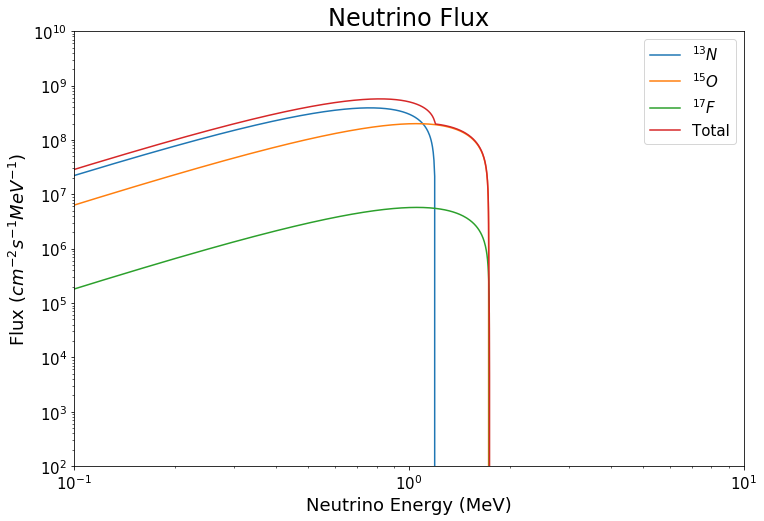

In [25]:
plt.figure(figsize = (12,8))
ax = plt.axes()
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-1,1e1)
plt.ylim(1e2,1e10)
ax.set_title('Neutrino Flux', fontsize = 24)
ax.set_ylabel('Flux ($cm^{-2}s^{-1}MeV^{-1})$', fontsize = 18)
ax.set_xlabel('Neutrino Energy (MeV)', fontsize = 18)
plt.plot(rawenergy_n13, flux_n13, label = '$^{13}N$')
plt.plot(rawenergy_o15, flux_o15, label = '$^{15}O$')
plt.plot(rawenergy_f17, flux_f17, label = '$^{17}F$')
plt.plot(totenergy,totflux, label = 'Total')
ax.legend(fontsize = 15)
plt.tick_params(labelsize=15)

# CNO Neutrino Interaction Generator

Start by defining the formula for the differential neutrino-electron scattering cross section. Also define t_max, which is the maximum energy the scattered electron can have given a certain neutrino energy.

In [26]:
g1 = 0.73
g2 = 0.23
sigma0 = 88.06 #88.06e-46 # cm2
me = 0.511 # Mev
e_nu = 1.5 # MeV

def xsec(te,enu):
    '''
    te is electron kinetic energy
    enu is neutrino energy
    '''
    return (sigma0 / me) * (g1**2 + g2**2 * (1 - te/enu)**2 - g1 * g2 * (me * te) / (enu**2))

def t_max(enu):
    '''
    returns the maximum allowed electron kinetic
    energy for a neutrino with energy enu
    '''
    return (2 * enu**2) / (me + 2 * enu)

## Differential neutrino-electron scattering cross section

See Giunti, Kim - Fundamentals of Neutrino Physics and Astrophysics, eq. 5.25.

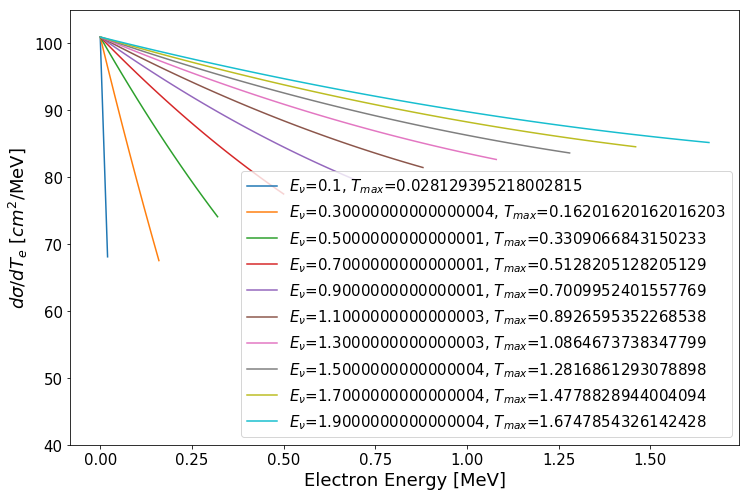

In [27]:
fig = plt.figure(figsize=(12,8),facecolor='w')
ax = fig.add_subplot(1,1,1)

for enu in np.arange(0.1, 2.0, 0.2):
    t = np.arange(0.0, t_max(enu), 0.02)
    plt.plot(t, xsec(t, enu), label=r'$E_\nu$='+str(enu)+', $T_{max}$='+str(t_max(enu)))
    
ax.legend(numpoints=1, loc='upper left')
leg=plt.legend(fontsize=15,loc=0)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
plt.ylabel(r'$d\sigma/dT_e$ [$cm^2$/MeV]',fontsize=18)
plt.xlabel(r'Electron Energy [MeV]',fontsize=18)
plt.tick_params(labelsize=15)
plt.ylim(40,105)
plt.show()

# Solar neutrino flux

In [28]:
def flux(x):
    a = interp1d(totenergy, totflux, kind = 'cubic', bounds_error = False, fill_value = 0)
    return a(x)

Find the maximum value of the flux. This is only needed for the generation of random values distributed following the flux spectrum.

In [29]:
from scipy.optimize import fminbound
def minus_flux(x): return -flux(x)
max_flux = fminbound(minus_flux, 0, 1.5)

## Random energies

The two following functions are random number generators that produce random number distributed according to the neutrino spectrum, and the electron spectrum.

They use the acceptance-rejection method for random number generation (see G. Cowan, Statistical Data Analysis 1998, sec. 3.3).

In [30]:
def shoot_neutrino(e_max=1.5):
    
    no_exit = True
    
    while(True):
        proposed_energy = random() * e_max
        r = random()
        if r < flux(proposed_energy) / max_flux:
            return proposed_energy

In [31]:
def shoot_electron(enu):
    tmax= t_max(enu)
    
    no_exit = True
    
    while(True):
        proposed_energy = random() * tmax
        r = random()
        if r < xsec(proposed_energy, enu) / xsec(0., enu):
            return proposed_energy

## Sample generation

Generated "n_samples" events. First generate a neutrino. The neutrino energy is sampled from the neutrino flux energy spectrum. Once we have a neutrino, sample the electron energy, acording to the electron energy distribution.
"samples" will contain all the generated events

In [32]:
n_tot_events = 21.777 # *** THIS HAS TO COME FROM (TOTAL_FLUX * TOTAL_Pee * TOTAL_CROSS_SECTION * N_TARGETS * TIME)
n_samples = 10000
samples = []
for i in range(0, n_samples):
    neutrino_energy = shoot_neutrino()
    electron_energy = shoot_electron(neutrino_energy)
    samples.append(electron_energy)

##  Plot electron energy distribution of events

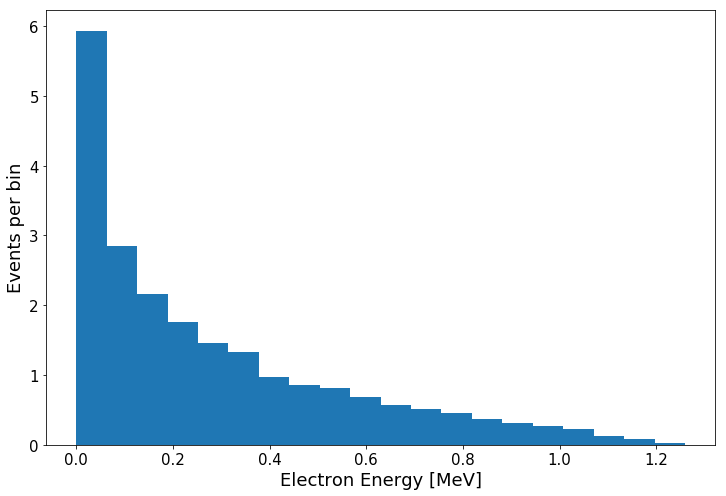

Number of events in histogram = 21.77699999999967


In [33]:
plt.figure(figsize=(12,8),facecolor='w')
ax2 = fig.add_subplot(1,1,1)

scale = float(n_tot_events) / n_samples

n, bins, patches = plt.hist(samples, bins=20, weights=len(samples)*[scale])

plt.ylabel('Events per bin',fontsize=18)
plt.xlabel('Electron Energy [MeV]',fontsize=18)
plt.tick_params(labelsize=15)

plt.show()

print ('Number of events in histogram =', np.sum(n))

# Solar Neutrino Background

Now make histograms of the backgrounds 8B, pp, both 7Be and pep. 

In [34]:
#Pull data on 8B neutrinos and scale

b_data = urllib.request.urlopen("http://www.sns.ias.edu/~jnb/SNdata/Export/B8spectrum/b8spectrum.txt")
page_b = b_data.read().decode("utf-8")
b_data.close()

lines_b = page_b.splitlines()

energy_b = []
rawflux_b = []
for line in range(16, 516):
    a = lines_b[line]
    energy_b.append(float(a[9:13]))
    rawflux_b.append(float(a[24:33]))
for line in range(516, len(lines_b) - 3):
    a = lines_b[line]
    energy_b.append(float(a[8:13]))
    rawflux_b.append(float(a[24:33]))
    
fluxarray_b = np.asarray(rawflux_b)*5.69e6


#Pull data on pp neutrinos and scale
pp_data = urllib.request.urlopen("http://www.sns.ias.edu/~jnb/SNdata/Export/PPenergyspectrum/ppenergytab")
page_pp = pp_data.read().decode("utf-8")
pp_data.close()

lines_pp = page_pp.splitlines()

energy_pp = []
rawflux_pp = []


for line in range(5, len(lines_pp)):
    a = lines_pp[line]
    energy_pp.append(float(a[:7]))
    rawflux_pp.append(float(a[9:15]))

for line in range(5, len(lines_pp)):
    a = lines_pp[line]
    energy_pp.append(float(a[17:24]))
    rawflux_pp.append(float(a[26:32]))

for line in range(5, len(lines_pp)):
    a = lines_pp[line]
    energy_pp.append(float(a[34:41]))
    rawflux_pp.append(float(a[43:49]))
    
for line in range(5, len(lines_pp)):
    a = lines_pp[line]
    energy_pp.append(float(a[51:58]))
    rawflux_pp.append(float(a[60:]))

fluxarray_pp = np.asarray(rawflux_pp)*5.99e10

Define flux functions for both of the backgrounds

In [35]:
def flux_b(x):
    a = interp1d(energy_b, fluxarray_b, kind = 'cubic', bounds_error = False, fill_value = 0)
    return a(x)

def flux_pp(x):
    a = interp1d(energy_pp, fluxarray_pp, kind = 'cubic', bounds_error = False, fill_value = 0)
    return a(x)

Find the maximum value of the flux in both cases

In [36]:
def minus_flux_b(x): return -flux_b(x)
max_flux_b = fminbound(minus_flux_b, 0, 1.5)

def minus_flux_pp(x): return -flux_pp(x)
max_flux_pp = fminbound(minus_flux_pp, 0, 1.5)

Shoot background neutrinos

In [37]:
def shoot_neutrino_b(e_max=20):
    
    no_exit = True
    
    while(True):
        proposed_energy = random() * e_max
        r = random()
        if r < flux_b(proposed_energy) / max_flux_b:
            return proposed_energy

def shoot_neutrino_pp(e_max=1.5):
    
    no_exit = True
    
    while(True):
        proposed_energy = random() * e_max
        r = random()
        if r < flux_pp(proposed_energy) / max_flux_pp:
            return proposed_energy

Background sample generation for all four backgrounds

In [38]:
n_tot_events_b = 0.193 # *** THIS HAS TO COME FROM (TOTAL_FLUX * TOTAL_Pee * TOTAL_CROSS_SECTION * N_TARGETS * TIME)
n_samples_b = 10000
samples_b = []
for i in range(0, n_samples_b):
    neutrino_energy = shoot_neutrino_b()
    electron_energy = shoot_electron(neutrino_energy)
    samples_b.append(electron_energy)
    
n_tot_events_pp = 2822.34 # *** THIS HAS TO COME FROM (TOTAL_FLUX * TOTAL_Pee * TOTAL_CROSS_SECTION * N_TARGETS * TIME)
n_samples_pp = 10000
samples_pp = []
for i in range(0, n_samples_pp):
    neutrino_energy = shoot_neutrino_pp()
    electron_energy = shoot_electron(neutrino_energy)
    samples_pp.append(electron_energy)
    
n_tot_events_7be862 = 201.623 # *** THIS HAS TO COME FROM (TOTAL_FLUX * TOTAL_Pee * TOTAL_CROSS_SECTION * N_TARGETS * TIME)
n_samples_7be862 = 10000
samples_7be862 = []
for i in range(0, n_samples_7be862):
    neutrino_energy = 0.826
    electron_energy = shoot_electron(neutrino_energy)
    samples_7be862.append(electron_energy)

n_tot_events_7be384 = 24.303 # *** THIS HAS TO COME FROM (TOTAL_FLUX * TOTAL_Pee * TOTAL_CROSS_SECTION * N_TARGETS * TIME)
n_samples_7be384 = 10000
samples_7be384 = []
for i in range(0, n_samples_7be384):
    neutrino_energy = 0.384
    electron_energy = shoot_electron(neutrino_energy)
    samples_7be384.append(electron_energy)
    
n_tot_events_pep = 6.245 # *** THIS HAS TO COME FROM (TOTAL_FLUX * TOTAL_Pee * TOTAL_CROSS_SECTION * N_TARGETS * TIME)
n_samples_pep = 10000
samples_pep = []
for i in range(0, n_samples_pep):
    neutrino_energy = 1.44
    electron_energy = shoot_electron(neutrino_energy)
    samples_pep.append(electron_energy)
    
    
scale_7be862 = float(n_tot_events_7be862) / n_samples_7be862

scale_7be384 = float(n_tot_events_7be384) / n_samples_7be384

scale_pep = float(n_tot_events_pep) / n_samples_pep
    

Plot background distribution for 8B

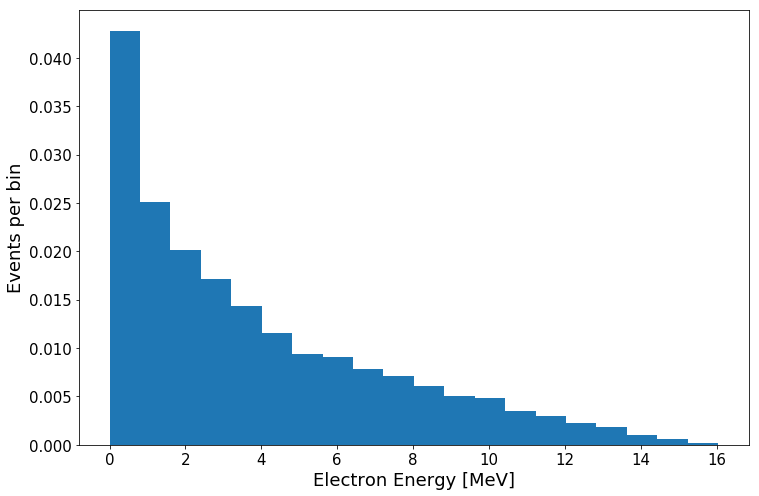

Number of events in histogram = 0.19299999999999906


In [39]:
#This is the histogram for 8B neutrinos

fig3 = plt.figure(figsize=(12,8))
ax3 = fig.add_subplot(1,1,1)

scale_b = float(n_tot_events_b) / n_samples_b

n, bins, patches = plt.hist(samples_b, bins=20, weights=len(samples_b)*[scale_b])

plt.ylabel('Events per bin',fontsize=18)
plt.xlabel('Electron Energy [MeV]',fontsize=18)
plt.tick_params(labelsize=15)

plt.show()

print ('Number of events in histogram =', np.sum(n))


Plot the background distribution for pp

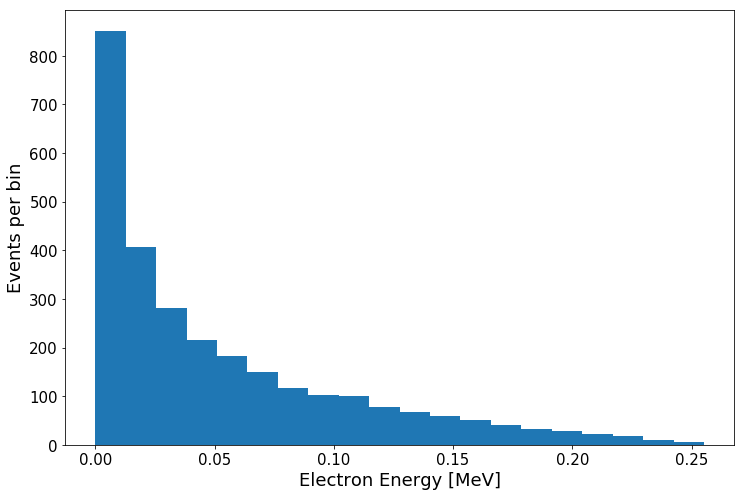

Number of events in histogram = 2822.3400000000315


In [40]:
fig4 = plt.figure(figsize=(12,8))
ax4 = fig.add_subplot(1,1,1)

scale_pp = float(n_tot_events_pp) / n_samples_pp

n, bins, patches = plt.hist(samples_pp, bins=20, weights=len(samples_pp)*[scale_pp])

plt.ylabel('Events per bin',fontsize=18)
plt.xlabel('Electron Energy [MeV]',fontsize=18)
plt.tick_params(labelsize=15)

plt.show()

print ('Number of events in histogram =', np.sum(n))

## Stacked Histogram

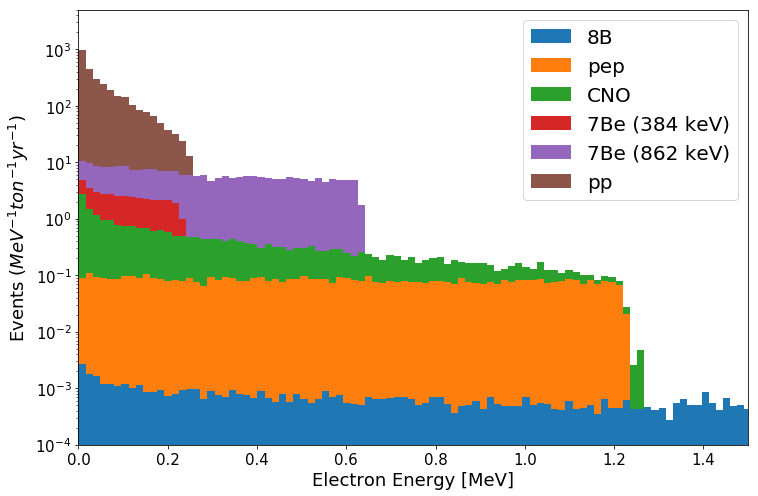

<Figure size 432x288 with 0 Axes>

In [41]:
n_nu= [samples_b, samples_pep, samples, samples_7be384, samples_7be862, samples_pp]

weight_cno = len(samples)*[scale]
weight_b = len(samples_b)*[scale_b]
weight_pp = len(samples_pp)*[scale_pp]
weight_7be862 = len(samples_7be862)*[scale_7be862]
weight_7be384 = len(samples_7be384)*[scale_7be384]
weight_pep = len(samples_pep)*[scale_pep]
weights_nu = [weight_b, weight_pep, weight_cno, weight_7be384, weight_7be862, weight_pp]

fig5 = plt.figure(figsize=(12,8))
ax5 = fig.add_subplot(1,1,1)
n, bins, patches = plt.hist(n_nu, bins=1000, weights=weights_nu, histtype = 'bar', label = ['8B', 'pep', 'CNO', '7Be (384 keV)', '7Be (862 keV)', 'pp'], log = True,  stacked = True)

plt.ylabel(r'Events ($MeV^{-1}ton^{-1}yr^{-1}$)',fontsize=18)
plt.xlabel('Electron Energy [MeV]',fontsize=18)
plt.tick_params(labelsize=15)

plt.xlim(0, 1.5)
plt.ylim(10e-5, 5000)
plt.legend(fontsize = 20)
plt.show()
plt.savefig('NEXT solar neutrino background.jpg', dpi = 300)
